In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
PATH = os.path.expanduser("~/data/dogbreed")
arch = resnet50
SZ = 196 # image size
bs = 48 # batch size (initial value of 64 was too large @ end and I couldn't reuse the saved models)

In [3]:
!ls {PATH}

labels.csv  models  test  tmp  train


In [3]:
label_csv = f'{PATH}/labels.csv'
with open(label_csv) as f: n = len(list(f)) - 1
val_idxs = get_cv_idxs(n)

In [4]:
val_idxs[:5]

array([2882, 4514, 7717,   33, 4924])

In [5]:
def get_data(f_model, sz, bs):
    """f_model: architecture, e.g. resnet34
    sz: scale images to sz by sz pixels
    bs: batch size (how many images to consider together)"""
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [6]:
data = get_data(arch, SZ, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [7]:
x, y = next(iter(data.val_dl))
#plt.imshow(data.val_ds.denorm(to_np(x))[0]);

In [8]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|████████▉ | 152/171 [00:03<00:00, 45.22it/s, loss=13.6]


In [33]:
?ConvLearner.pretrained

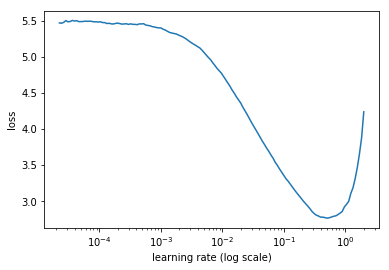

In [9]:
learn.sched.plot()

In [10]:
learn.fit(0.08, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.965177   0.563815   0.824336  
    1      0.68497    0.572554   0.833749                    
    2      0.584705   0.609738   0.831603                    



[0.6097378, 0.8316029892411343]

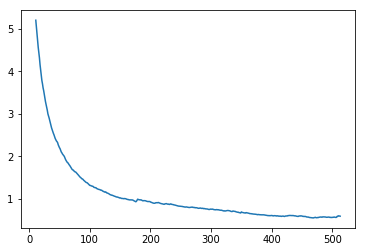

In [11]:
learn.sched.plot_loss()

In [12]:
learn.save("196_pre")

In [13]:
learn.load("196_pre")

In [14]:
learn.precompute = False
learn.fit(0.08, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.607346   0.533733   0.842954  
    1      0.599871   0.551588   0.834856                    
    2      0.527271   0.532895   0.838109                    



[0.53289527, 0.8381090760231018]

In [15]:
learn.save("196_no_precompute")

In [17]:
learn.load("196_no_precompute")

In [18]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 62%|██████▏   | 106/171 [00:50<00:30,  2.11it/s, loss=2.48]

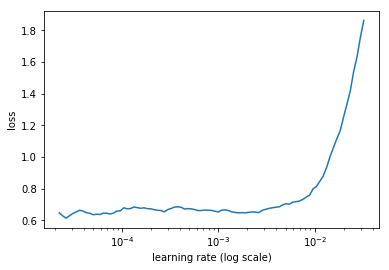

In [20]:
learn.sched.plot()

In [21]:
lrs = 0.002 * np.array([0.04, 0.2, 1])
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 0/171 [00:00<?, ?it/s]                     


Exception in thread Thread-19:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.55945    0.601622   0.824197  
    1      0.501596   0.564156   0.833403                    
    2      0.4393     0.566393   0.835341                    



[0.56639344, 0.8353405289871748]

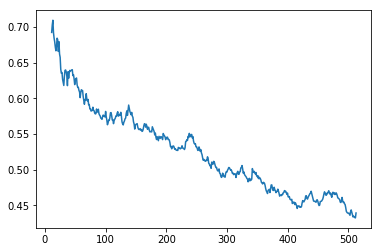

In [22]:
learn.sched.plot_loss()

In [23]:
learn.save("196_unfr_after_3")

In [24]:
SZ = 299
learn.set_data(get_data(arch, SZ, bs))
learn.freeze()

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [25]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 150/171 [01:02<00:08,  2.40it/s, loss=1.59] 

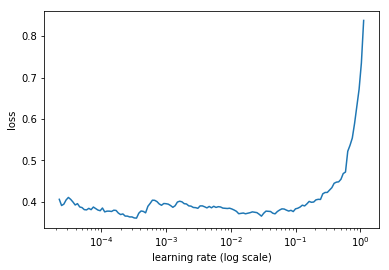

In [26]:
learn.sched.plot()

In [29]:
learn.load("196_unfr_after_3")
SZ = 256
learn.set_data(get_data(arch, SZ, bs))
learn.precompute = False
learn.freeze()
learn.fit(0.001, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.344729   0.458458   0.862542  
    1      0.320644   0.457908   0.862818                    
    2      0.34196    0.459405   0.861226                    
    3      0.325923   0.459421   0.864133                    
    4      0.334274   0.458679   0.861849                    
    5      0.327603   0.454593   0.863995                    
    6      0.332563   0.453419   0.861088                    



[0.45341885, 0.8610880430354628]

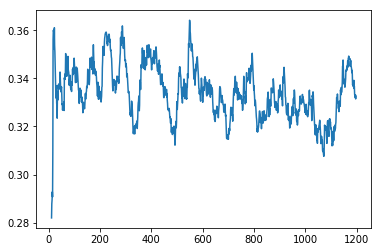

In [30]:
learn.sched.plot_loss()

In [31]:
learn.save("256_frozen")

In [32]:
learn.unfreeze()
lrs = 0.001 * np.array([0.04, 0.2, 1])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.364833   0.448671   0.868148  
    1      0.356896   0.446316   0.874169                    
    2      0.309296   0.447363   0.869947                    
    3      0.317946   0.440536   0.868978                    
    4      0.305993   0.438225   0.874792                    
    5      0.262826   0.436493   0.87237                     
    6      0.25184    0.431728   0.873339                    



[0.4317277, 0.8733388615209002]

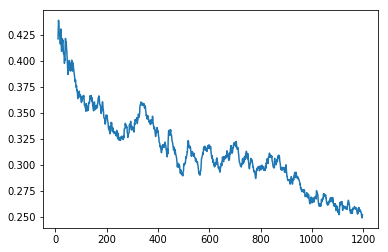

In [33]:
learn.sched.plot_loss()

In [34]:
learn.save("256_unfr_after_3")

In [37]:
lrs = 0.0005 * np.array([0.01, 0.1, 1])
learn.fit(lrs, 4, cycle_len=1, cycle_mult=2, best_save_name="256_unfr_best_while_4")

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.256744   0.429702   0.87673   
    1      0.259552   0.433207   0.872854                    
    2      0.262131   0.4351     0.879153                    
    3      0.264028   0.431271   0.876592                    
    4      0.249582   0.432064   0.875277                    
    5      0.235805   0.42779    0.881921                    
    6      0.254208   0.430999   0.881921                    
    7      0.259338   0.437192   0.876246                    
    8      0.260301   0.436833   0.876107                    
    9      0.255556   0.437535   0.877699                    
    10     0.246132   0.433726   0.877699                    
    11     0.248999   0.434737   0.875761                    
    12     0.228133   0.436297   0.873823                    
    13     0.232373   0.429649   0.879014                    
    14     0.228137   0.435605   0.875761                    



[0.43560463, 0.8757613467615705]

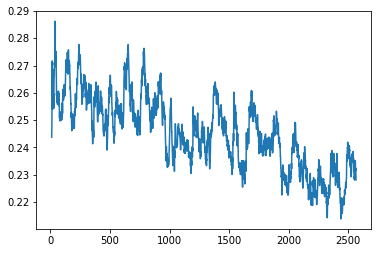

In [39]:
learn.sched.plot_loss()

In [40]:
learn.save("256_after_4")

In [41]:
learn.load("256_unfr_best_while_4")

In [42]:
log_preds,y = learn.TTA(n_aug=8)
probs = np.mean(np.exp(log_preds),0)

In [43]:
accuracy_np(probs, y)

0.8855185909980431

In [44]:
import sklearn.metrics

In [47]:
log_preds.shape, y.shape

((10, 2044, 120), (2044,))

In [49]:
sklearn.metrics.log_loss(y, probs)

0.3894177411726202

If my intrepretation of `sklearn.metrics.log_loss` is correct, on [2018-04-06], I am about 570th with this model.